In [3]:
from util.sparkhandler import SparkHandler
from util.dataproctools import get_extracted_wet, save_rdd, load_rdd
from util.dataproctools import extracted_wet_to_df
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
from util.updatedVIZ import visualize_topics
import optuna

In [4]:
handler = SparkHandler(available_cores=36, driver_mem = 35, executor_mem = 35, mem_overhead = 35) # look at the parameters for SparkHandler to increase max memory
ss = handler.get_spark_session()
sc = handler.get_spark_context()

In [5]:
raw_data = get_extracted_wet(spark_context=sc, approx_sample_size=200000, wet_paths_file="data/wet.paths")
save_rdd(raw_data, "saved_intermediates/rawStrRDD", overwrite=True)

25/12/10 20:38:18 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
# raw_data = load_rdd(spark_context=sc, path_to_load="../saved_intermediates/rawStrRDD")

In [7]:
df = extracted_wet_to_df(spark_session=ss, extracted_wet_rdd=raw_data)
filtered = df.filter(((df.tld == '.gov') | (df.tld == '.edu')) & (df.languages == 'eng'))
filtered.write.mode("overwrite").format("json").save("saved_intermediates/filtered_dataframe")

In [10]:
loaded_df = ss.read.json("saved_intermediates/filtered_dataframe")

In [11]:
# loaded_df.head()

In [12]:
tuning_sample = loaded_df.sample(0.2)
train, val, test = tuning_sample.randomSplit([0.7, 0.2, 0.1], seed=1237)

In [13]:
def objective(trial: optuna.trial.Trial):

    minTokenLength = trial.suggest_int("min word len", 1, 3)
    k = 12
    learningDecay = trial.suggest_float("lr decay", 0.5, 1.0)
    learningOffset = trial.suggest_float("offset", 0, 10)
    maxItr = trial.suggest_int("intrs", 10, 100)
    subsamplingRate = trial.suggest_float("subsampling rate", 0, 1)

    # 1) Tokenize text into tokens
    tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

    # 2) Remove stopwords
    remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

    # 3) Convert tokens to term-frequency vectors
    cv = CountVectorizer(
        inputCol="filtered",
        outputCol="features",
        vocabSize=5000,
        minDF=1    # keep terms that appear in at least 1 document
    )

    # 4) LDA model (k = number of topics)
    lda = LDA(
        k=k,
        learningDecay=learningDecay,
        learningOffset=learningOffset,
        maxIter=maxItr,
        subsamplingRate=subsamplingRate,
        featuresCol="features"
    )

    # 5) Build pipeline
    pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
    model = pipeline.fit(train)
    valed = model.transform(val)
    perplexity = model.stages[-1].logPerplexity(valed)
    log_likelyhood = model.stages[-1].logLikelihood(valed)
    return perplexity, log_likelyhood

In [14]:
study = optuna.create_study(directions=["minimize", "maximize"])

[I 2025-12-10 20:38:39,992] A new study created in memory with name: no-name-fac4b811-9366-4e56-8569-7bd422857679


In [16]:
study.optimize(objective, n_trials=200, timeout=300, n_jobs=20)

[I 2025-12-10 20:39:16,863] Trial 12 finished with values: [8.775857788180659, -398739.8744637765] and parameters: {'min word len': 2, 'lr decay': 0.6667972064910754, 'offset': 3.5140501795372616, 'intrs': 12, 'subsampling rate': 0.27165827422587663}.
[I 2025-12-10 20:39:16,954] Trial 10 finished with values: [9.16224931766244, -416854.857205688] and parameters: {'min word len': 2, 'lr decay': 0.6727034323612939, 'offset': 7.797769682328493, 'intrs': 11, 'subsampling rate': 0.09191006926384382}.
[I 2025-12-10 20:39:20,283] Trial 23 finished with values: [8.665362186895518, -387220.3746836131] and parameters: {'min word len': 3, 'lr decay': 0.5357620617635486, 'offset': 3.83821760386839, 'intrs': 15, 'subsampling rate': 0.7283819085425126}.
[I 2025-12-10 20:39:20,578] Trial 19 finished with values: [8.79765836677389, -393052.98285235715] and parameters: {'min word len': 3, 'lr decay': 0.6050853004010099, 'offset': 6.529237232841684, 'intrs': 14, 'subsampling rate': 0.661037982783519}.
[

[I 2025-12-10 20:40:14,815] Trial 17 finished with values: [8.601291796377705, -391281.36510901817] and parameters: {'min word len': 2, 'lr decay': 0.8514234508534214, 'offset': 0.5121484043788216, 'intrs': 89, 'subsampling rate': 0.5646402060426483}.
[I 2025-12-10 20:40:18,206] Trial 51 finished with values: [9.67599277312529, -440247.9951844276] and parameters: {'min word len': 2, 'lr decay': 0.6668345682470862, 'offset': 0.20380173573023797, 'intrs': 14, 'subsampling rate': 0.013976579651701848}.
[I 2025-12-10 20:40:23,523] Trial 56 finished with values: [11.44904144970025, -512001.13363059517] and parameters: {'min word len': 3, 'lr decay': 0.6081966294849493, 'offset': 3.0334949327835945, 'intrs': 12, 'subsampling rate': 0.0013759721859385454}.
[I 2025-12-10 20:40:27,549] Trial 58 finished with values: [9.15710593145953, -409313.4780303095] and parameters: {'min word len': 3, 'lr decay': 0.9200723757155294, 'offset': 6.840022453117786, 'intrs': 17, 'subsampling rate': 0.5976673531

[I 2025-12-10 20:41:16,382] Trial 76 finished with values: [8.493668132988814, -420011.8891762969] and parameters: {'min word len': 1, 'lr decay': 0.7127503176133896, 'offset': 4.407253764963874, 'intrs': 33, 'subsampling rate': 0.2992044843344944}.
[I 2025-12-10 20:41:16,592] Trial 55 finished with values: [8.727873068113047, -389874.0899526098] and parameters: {'min word len': 3, 'lr decay': 0.8903144069466933, 'offset': 8.852535765866653, 'intrs': 100, 'subsampling rate': 0.8817812360793028}.
[I 2025-12-10 20:41:19,064] Trial 77 finished with values: [8.540198665236156, -422235.9622079407] and parameters: {'min word len': 1, 'lr decay': 0.7127503176133896, 'offset': 2.468124288611947, 'intrs': 33, 'subsampling rate': 0.29738608980895276}.
[I 2025-12-10 20:41:19,462] Trial 82 finished with values: [8.5923169816935, -383844.57652319374] and parameters: {'min word len': 3, 'lr decay': 0.6311831353549986, 'offset': 4.124895629441598, 'intrs': 30, 'subsampling rate': 0.49669351112481197}

[I 2025-12-10 20:42:11,159] Trial 103 finished with values: [8.750736388972319, -432680.1607527364] and parameters: {'min word len': 1, 'lr decay': 0.9605951846512852, 'offset': 5.57594347069692, 'intrs': 60, 'subsampling rate': 0.09761769801447118}.
[I 2025-12-10 20:42:12,904] Trial 117 finished with values: [8.608918615343397, -425650.7630984236] and parameters: {'min word len': 1, 'lr decay': 0.6010375073685975, 'offset': 5.299651016478549, 'intrs': 19, 'subsampling rate': 0.9678804555063713}.
[I 2025-12-10 20:42:13,568] Trial 104 finished with values: [9.016617712363031, -402835.42953524325] and parameters: {'min word len': 3, 'lr decay': 0.9691405166146639, 'offset': 3.6643510700205706, 'intrs': 57, 'subsampling rate': 0.03219340160869788}.
[I 2025-12-10 20:42:15,099] Trial 106 finished with values: [8.408314908856196, -375599.42697860627] and parameters: {'min word len': 3, 'lr decay': 0.5010457909013699, 'offset': 1.7368384748920285, 'intrs': 58, 'subsampling rate': 0.0936966580

[I 2025-12-10 20:43:08,067] Trial 124 finished with values: [8.367943056033202, -413451.6984555444] and parameters: {'min word len': 1, 'lr decay': 0.6963332587620119, 'offset': 0.2955130202849987, 'intrs': 99, 'subsampling rate': 0.2992044843344944}.
[I 2025-12-10 20:43:09,722] Trial 151 finished with values: [8.779090305676501, -434134.79470600875] and parameters: {'min word len': 1, 'lr decay': 0.72415501974465, 'offset': 9.27679956897576, 'intrs': 19, 'subsampling rate': 0.88857884311538}.
[I 2025-12-10 20:43:13,082] Trial 148 finished with values: [8.476945978665942, -385633.22646147106] and parameters: {'min word len': 2, 'lr decay': 0.6182170758856238, 'offset': 0.2955130202849987, 'intrs': 34, 'subsampling rate': 0.2992044843344944}.
[I 2025-12-10 20:43:15,314] Trial 147 finished with values: [8.64129894268148, -393127.2540983513] and parameters: {'min word len': 2, 'lr decay': 0.810000026286251, 'offset': 4.124895629441598, 'intrs': 39, 'subsampling rate': 0.2557106144628294}.

[I 2025-12-10 20:44:06,462] Trial 180 finished with values: [8.459024401772774, -417884.26447197684] and parameters: {'min word len': 1, 'lr decay': 0.525268489390979, 'offset': 1.3774924395629906, 'intrs': 33, 'subsampling rate': 0.7989457385382203}.
[I 2025-12-10 20:44:06,710] Trial 172 finished with values: [8.603403397892963, -391041.891241031] and parameters: {'min word len': 2, 'lr decay': 0.8321443670994519, 'offset': 7.1867076931020355, 'intrs': 60, 'subsampling rate': 0.2557106144628294}.
[I 2025-12-10 20:44:07,701] Trial 175 finished with values: [8.364332192406168, -413306.746623366] and parameters: {'min word len': 1, 'lr decay': 0.5251311445709732, 'offset': 9.88248805149431, 'intrs': 51, 'subsampling rate': 0.36769703621738203}.
[I 2025-12-10 20:44:08,512] Trial 163 finished with values: [8.441999296797308, -383807.05602959276] and parameters: {'min word len': 2, 'lr decay': 0.5694982711273233, 'offset': 6.091474038753747, 'intrs': 85, 'subsampling rate': 0.26756569696381

In [18]:
best_params = study.best_trials[-1].params
best_params

{'min word len': 3,
 'lr decay': 0.5010457909013699,
 'offset': 1.0844539501451,
 'intrs': 58,
 'subsampling rate': 0.10615490760139012}

In [19]:
#def objective(trial: optuna.trial.Trial):

minTokenLength = best_params['min word len']
k = 12
learningDecay = best_params['lr decay']
learningOffset = best_params['offset']
maxItr = best_params['intrs']
subsamplingRate = best_params['subsampling rate']

# 1) Tokenize text into tokens
tokenizer = RegexTokenizer(minTokenLength=minTokenLength, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

# 2) Remove stopwords
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

# 3) Convert tokens to term-frequency vectors
cv = CountVectorizer(
    inputCol="filtered",
    outputCol="features",
    vocabSize=5000,
    minDF=1    # keep terms that appear in at least 1 document
)

# 4) LDA model (k = number of topics)
lda = LDA(
    k=k,
    learningDecay=learningDecay,
    learningOffset=learningOffset,
    maxIter=maxItr,
    subsamplingRate=subsamplingRate,
    featuresCol="features"
)

# 5) Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])
model = pipeline.fit(loaded_df)
transformed = model.transform(loaded_df)

In [20]:
# Extract the CV and LDA sub-models
cv_model = model.stages[2]
lda_model = model.stages[3]

vocab = cv_model.vocabulary

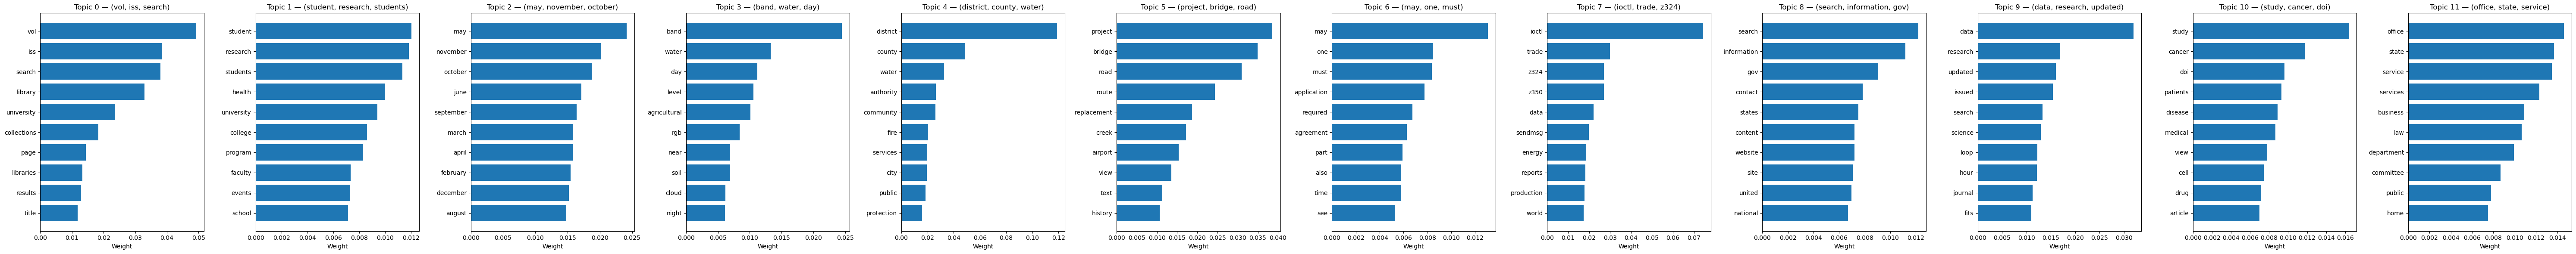

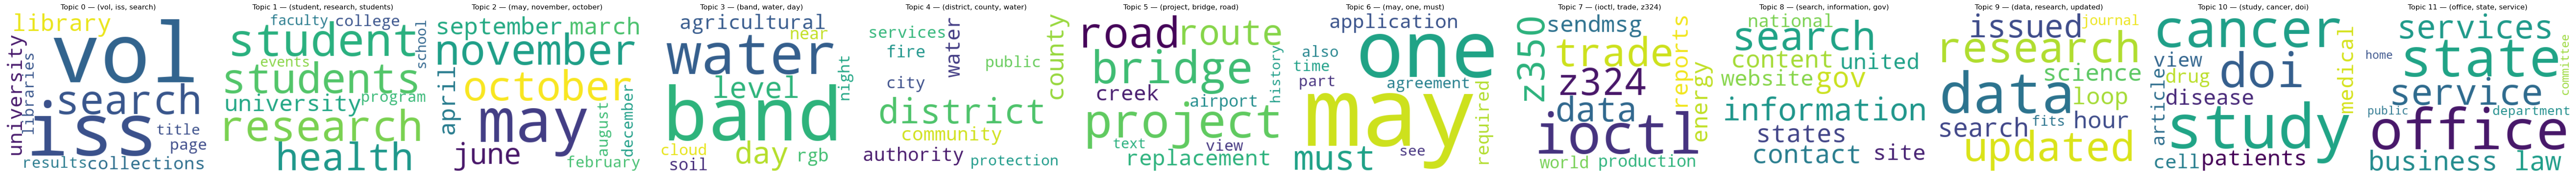

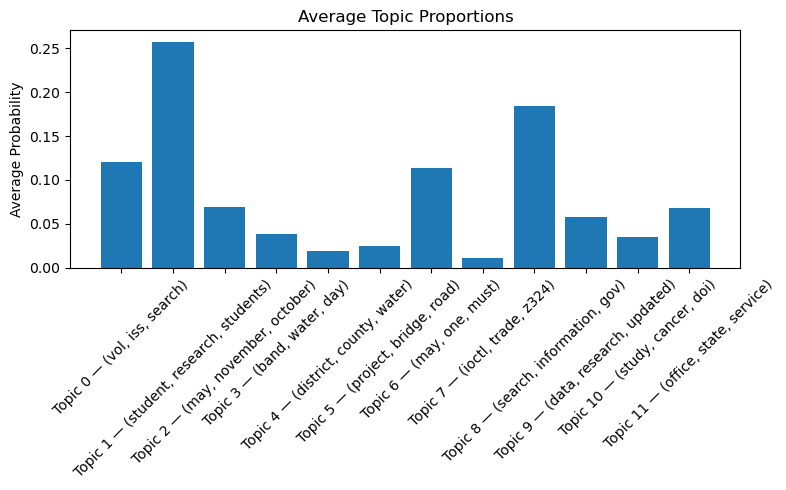

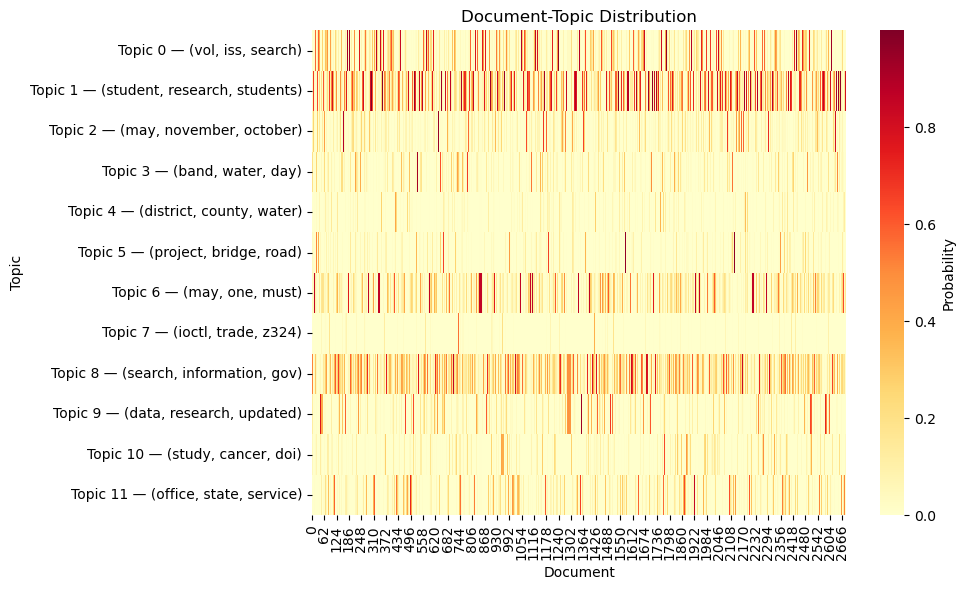

In [21]:
visualize_topics(lda_model, vocab, transformed, num_words=10)

In [22]:
optuna.visualization.plot_pareto_front(study, target_names=["perplexity", "log likelyhood"]).write_html("visualization_outputs/pareto_front.html")
optuna.visualization.plot_param_importances(study).write_html("visualization_outputs/param_importances.html")

In [23]:
ss.stop()